# Cluster (at h3 level 9) or Topic Modeling Using street view images
1. Test simple k-mean with the segmentation results
2. Test topic modeling method

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
from haversine import haversine, Unit
import h3
from tqdm import tqdm
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn import manifold

In [130]:
# CURATED_FOLDER_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional"
# CURATED_PANO_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_crossectional"
CURATED_FOLDER_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_crossectional_all"
CURATED_PANO_CROSS = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_pano_crossectional"
RAW_PATH = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{city}/gsvmeta/{city}_meta.csv"
GRAPHIC_PATH = "/lustre1/g/geog_pyloo/05_timemachine/_graphic"
if not os.path.exists(GRAPHIC_PATH):
    os.makedirs(GRAPHIC_PATH)


In [5]:
def get_cross(curated_cross):
    segfiles = glob(curated_cross+"/*.parquet")
    df_seg = []
    for f in tqdm(segfiles):
        temp = pd.read_parquet(f)
        temp["city_lower"] = f.split("/")[-1].split(".")[0]
        df_seg.append(temp)
    df_seg = pd.concat(df_seg).reset_index(drop = True)
    return df_seg

In [85]:
df_seg = get_cross(CURATED_FOLDER_CROSS)
# select level 9 only
df_seg = df_seg[df_seg['res'] == 9].reset_index(drop = True)
# df_pano = get_cross(CURATED_PANO_CROSS)

100%|██████████| 127/127 [00:24<00:00,  5.13it/s]


In [86]:
# select level 9 only
df_seg = df_seg[df_seg['res'] == 9].reset_index(drop = True)
# df_pano = df_pano[df_pano['res'] == 9].reset_index(drop = True)
df_seg = df_seg.fillna(0)

## 1. Simple cmean

In [9]:
# use segmentation alone and do a simple k-mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score, silhouette_samples

In [10]:
def inertia_array(fcm, data):
    """
    It is calculated by measuring the distance between each data point and its centroid, 
    squaring this distance, and summing these squares across one cluster. 
    A good model is one with low inertia AND a low number of clusters ( K ). """
    dist = 0
    prediction = fcm.predict(data)
    centers = fcm.centers
    for idx in range(len(prediction)):
        center = centers[prediction[idx],:]
        dist += ((center - data[idx,:]) ** 2).sum()
    return dist

def construct_vec(arr, log10):
    #Construct vector: pattern only
    if arr.sum() != 0:
        if log10:
            arr = np.log10(arr + 1)
        pattern = arr / arr.sum()
        return pattern
    else:
#         return arr
        return np.zeros(arr.shape[0])

def f_cmeans(pattern_df, n_clusters, log10, random_state):
    '''
    input: 
    pattern_df: dictionary of ID-Pattern pairs
    beta: beta value to balance volume and pattern
    n_clusters: number of clusters
    vector_mode: 1 or 2, 1 means construct vector from paper, 2 means our own method
    output:
    ndarry, cluster result for each id
    '''
    # construct vector
    data = np.zeros(pattern_df.shape)
    if type(pattern_df) == pd.core.frame.DataFrame:
        for count, idx in enumerate(pattern_df.index):
            data[count, :] = construct_vec(pattern_df.iloc[count], log10)
    elif type(pattern_df) == np.ndarray:
        for count in range(pattern_df.shape[0]):
            data[count, :] = construct_vec(pattern_df[count, :], log10)
    
    # # standardize the data
    # if standardize:
    #     scaler = StandardScaler().fit(data)
    #     data = scaler.transform(data)
    
    # fit data into fuzzy-c-means model
    fcm = FCM(n_clusters=n_clusters, random_state=random_state)
    fcm.fit(data)
    
    return fcm, data

In [82]:
def load_class():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "object150"
    obj_meta, other_worksheet = read_url(url, SHEETNAME)
    return obj_meta

obj_meta = load_class()

In [83]:

obj_meta["id"] = obj_meta["id"].astype(str)
ADE_CATEGORIES_DICT = dict(zip(
    obj_meta["id"].values, 
    obj_meta["category"].values))

In [90]:
new_cols = []
for x in df_seg.columns:
    if x in obj_meta["id"].values:
        new_cols.append(ADE_CATEGORIES_DICT[x])
    else:
        new_cols.append(x)
df_seg.columns = new_cols


In [128]:
# drop the columns if all value are 0
variables = set([v for v in df_seg.columns if v in obj_meta["category"].unique()])
print("Variables original: ",len(variables))
to_drop = ["other"]

variables_remain = [v for v in variables if not v in to_drop]
print("Variables kept: ",len(variables_remain))

Variables original:  30
Variables kept:  29


In [115]:
# combine categories and transform
df_long = df_seg.set_index(['city_lower','hex_id', 'img_count']).stack().reset_index()
df_long.rename(columns = {'level_3':'category', 0:'value'}, inplace = True)
df_long["value"] = df_long["value"].astype(float)

df_seg_update = df_long.groupby(['city_lower',"hex_id",'img_count', "category"])["value"].sum().reset_index()\
    .pivot(columns = "category", index = ['city_lower',"hex_id",'img_count'], values = "value").reset_index()
df_seg_update

In [119]:
df_seg_update.describe()

category,img_count,bike,building,bus,car,grass,ground,house,installation,lake+waterboday,...,skyscraper,sportsfield,table+chair,tower,traffic light,trashcan,tree,truck,van,wall
count,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,...,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000,567073.000000
mean,67.207913,104.766140,14668.544405,92.480531,2884.318591,4177.546044,20.395739,659.270544,1458.134280,2031.011751,...,10.755293,4558.541640,28.677986,9.797771,13.787946,29.558083,20252.516271,358.670012,209.589007,2964.612166
std,48.487946,361.186974,16717.898639,418.735839,3632.886331,5790.389364,239.103687,1514.192362,2885.518956,6531.016167,...,152.651871,9910.322328,166.302554,84.964612,59.400604,121.379968,16892.548699,1000.361227,434.344783,4686.517768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2161.157895,0.000000,214.241379,261.134615,0.000000,0.000000,91.666667,0.000000,...,0.000000,5.258824,0.000000,0.000000,0.000000,0.000000,7520.666667,0.000000,0.000000,371.750000
50%,62.000000,0.423077,8307.250000,0.000000,1496.175000,1814.433333,0.000000,18.555556,470.252336,76.982759,...,0.000000,286.396552,0.602151,0.000000,0.000000,0.208333,16045.821429,37.593407,35.375000,1424.318182
75%,112.000000,39.784483,21978.375000,12.316667,4204.778947,5900.750000,0.000000,516.055556,1488.288136,1026.178218,...,0.000000,3547.375000,14.325000,0.000000,0.000000,19.133333,28444.583333,311.800000,244.658333,3822.120000
max,1756.000000,24776.750000,180885.861111,48887.250000,84289.000000,116031.500000,34413.250000,45786.333333,79160.000000,177420.000000,...,16189.218750,157153.500000,21442.666667,13580.000000,6031.750000,12234.000000,216120.750000,48703.500000,26906.000000,159998.000000


## 1. Option 1. Direct standard scale 

In [127]:
scaler = StandardScaler().fit(df_seg_update[variables_remain])
data = scaler.transform(df_seg_update[variables_remain])

29


/tmp/jobtmp-yuanzf-1653159/ipykernel_2137344/3172033199.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(c_min-1,c_max), np.array(scores), 'bx-', color='black')


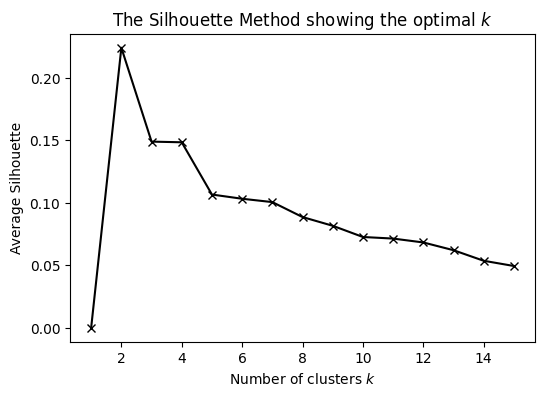

In [39]:
# scores = [0]
# c_min = 2
# c_max = 16
# for i in range(c_min, c_max):
#     fcm = FCM(n_clusters=i,random_state=0)
#     fcm.fit(data)
#     prediction = fcm.predict(data)
#     score = silhouette_score(data, prediction)
#     scores.append(score)
# plt.figure(figsize=(6,4))
# plt.plot(range(c_min-1,c_max), np.array(scores), 'bx-', color='black')
# plt.xlabel('Number of clusters $k$')
# plt.ylabel('Average Silhouette')
# plt.title('The Silhouette Method showing the optimal $k$')
# # plt.savefig(os.path.join(figpath,"silhouette_volume_{}.png".format(radius)), dpi=600, bbox_inches = 'tight')
# plt.show()

/tmp/jobtmp-yuanzf-1653304/ipykernel_3594380/3494865467.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2,N), wss, 'bx-', color='black')


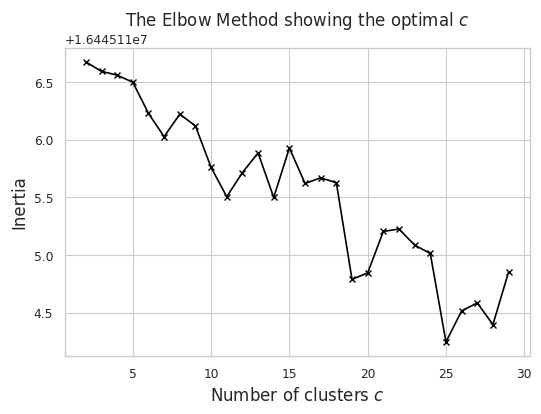

In [139]:
import seaborn as sns
# wss = []
# WSS stands for Within-Cluster Sum of Squares.

def plot_wss(data, N, comment):
    wss = []
    for i in range(0,N):
        print("cluster: ", i)
        fcm_vol = FCM(n_clusters=i, random_state=0)
        fcm_vol.fit(data)
        wss.append(inertia_array(fcm_vol, data))
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})

    plt.figure(figsize=(6,4))
    plt.plot(range(2,N), wss, 'bx-', color='black')
    # plt.grid(True,alpha=.3)
    # plt.legend(framealpha=.3)
    plt.xlabel('Number of clusters $c$')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal $c$')
    plt.savefig(os.path.join(GRAPHIC_PATH,f"elbow_volume_{N}_{comment}.png"), dpi=200, bbox_inches = 'tight')
    plt.show()

In [140]:
# based on the results, let's use n = 8
n = 19
fcm_pattern, data_pattern = f_cmeans(data, n_clusters=n, log10 = False,  random_state=0)
prediction_pattern = fcm_pattern.predict(data)

### Use the PCA to visualize the cluster

In [141]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')

In [ ]:
# use tsn to do cluster
output_tsne_data = get_tsne(data)
print("TSN done")
# plot_representations(output_tsne_data, prediction_pattern)

In [ ]:
plot_wss(output_tsne_data, 20, "TSNE")

In [142]:
df_seg["class"] = prediction_pattern
data_des = pd.DataFrame(data, columns = variables_remain)
data_des["class"] = prediction_pattern

In [143]:
data_des.groupby("class").size()

class
0     311084
2       7083
4       3322
5       2797
6     241733
8        131
9        253
16       595
18        75
dtype: int64

In [151]:
# summarize the class type
df_summary = data_des[variables_remain+["class"]].groupby("class").mean().stack().reset_index()\
.rename(columns = {"level_1":"variable", 0:"std_value"})
# re-normalize the mean value for visualization usage
df_summary["norm_value"] = df_summary.groupby("variable")\
.apply(lambda x: (x["std_value"] - x["std_value"].min())/(x["std_value"].max() - x["std_value"].min()))\
.reset_index(drop=True)["std_value"]
df_summary

KeyError: 'std_value'

In [155]:
df_summary_update = []
for v in df_summary["variable"].unique():
    temp = df_summary[df_summary["variable"]==v].reset_index(drop = True)
    temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
    df_summary_update.append(temp)

In [157]:
df_summary_update = pd.concat(df_summary_update).reset_index()

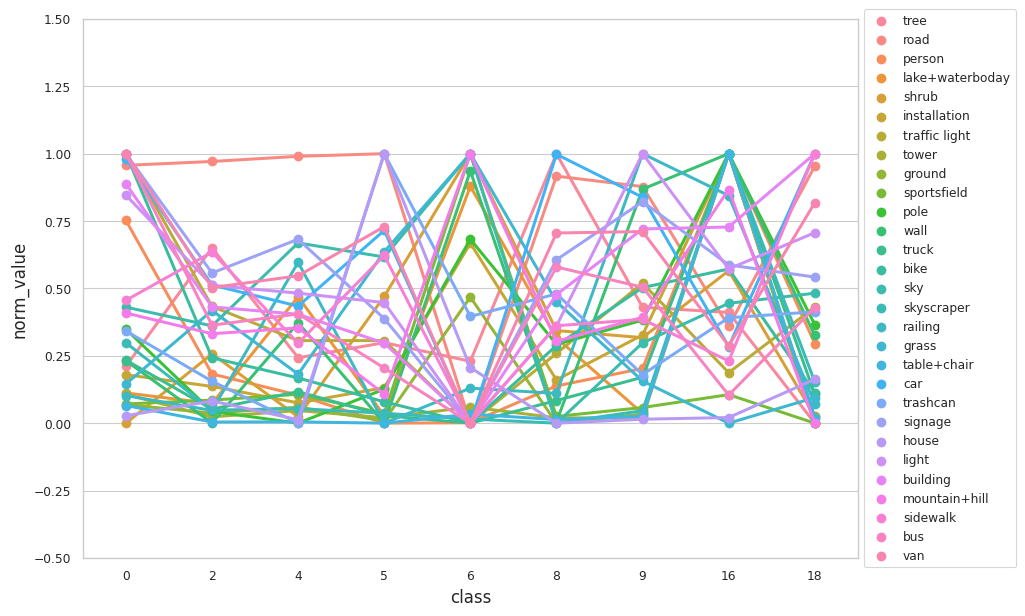

In [160]:
fig, ax = plt.subplots(figsize = (10,7))
sns.pointplot(
    data = df_summary_update,
    x = 'class',
    y = 'norm_value',
    hue = "variable"
)
ax.set_ylim([-0.5, 1.5])

# put the legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [148]:
# get the geometry
from shapely.geometry import Polygon
import geopandas as gpd

def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

city = "London"
cityabbr = city.lower().replace(" ", "")
sample = df_seg[df_seg["city_lower"]==cityabbr].reset_index(drop = True)
h3_geoms = sample['hex_id'].apply(lambda x: cell_to_shapely(x))
df_sel_gdf = gpd.GeoDataFrame(sample[['hex_id',"class"]], geometry = h3_geoms)
df_sel_gdf.crs = "EPSG:4326"
df_sel_gdf['class'] = df_sel_gdf['class'].astype(str)

<Axes: >

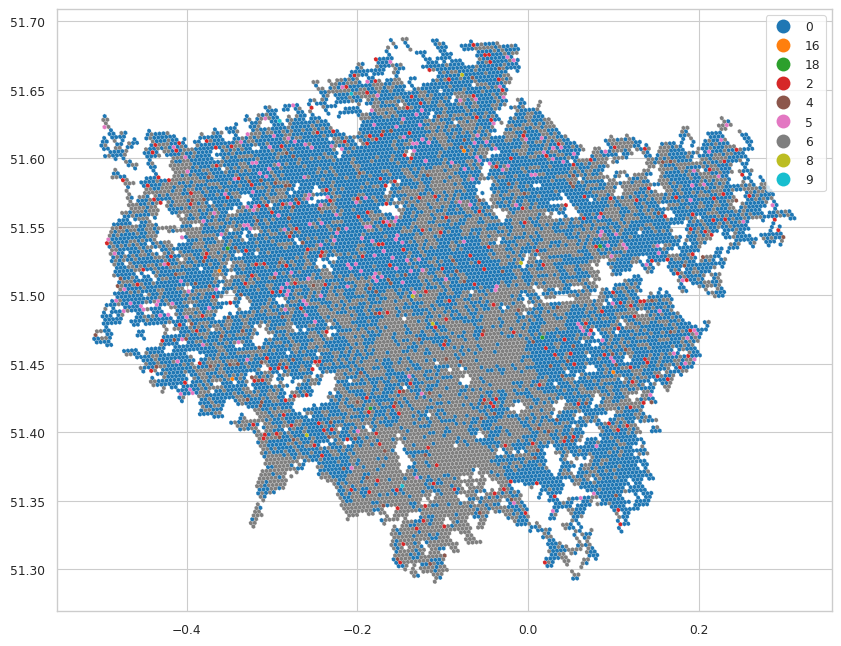

In [150]:

df_sel_gdf.plot(figsize = (10,10), column = "class", legend = True, linewidth = 0.1)